In [1]:
%load_ext autoreload
%autoreload 2

from torchvision.io import read_image
import torchvision.transforms.functional as TF
import torch

image = read_image('data/images/collins.png')
image = TF.to_pil_image(image)
prompt = "A Female astronaut in orange uniform holding helmet"


In [2]:
from diffusers import StableDiffusionPipeline

device = 'cuda'
dtype = torch.float16
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=dtype).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
image_input = TF.to_tensor(image).unsqueeze(0).to(device, dtype) * 2 - 1
with torch.no_grad():
    latent = pipe.vae.encode(image_input)

latent = 0.18215 * latent.latent_dist.sample()

In [7]:

from text3d2video.inversion import invert_latent


intermediate_latents = invert_latent(pipe, latent, prompt)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:283: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 79/79 [00:03<00:00, 21.58it/s]


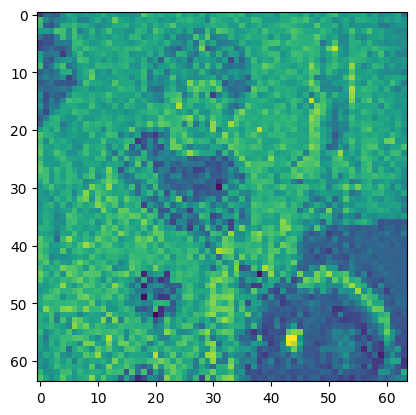

In [20]:
from matplotlib import pyplot as plt


latent = intermediate_latents[4]

plt.imshow(latent[0].cpu())